# Loop 63 Analysis: CV-LB Relationship and Strategy Review

## Key Questions:
1. What is the exact CV-LB relationship?
2. Why have 7 consecutive submissions failed?
3. What approaches haven't been tried yet?
4. How can we reduce the intercept?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},  # Best LB
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print("Submission History:")
print(df)
print(f"\nBest LB: {df['lb'].min():.4f} (exp_030)")
print(f"Best CV: {df['cv'].min():.4f} (exp_030)")
print(f"Target: 0.0347")

Submission History:
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970

Best LB: 0.0877 (exp_030)
Best CV: 0.0083 (exp_030)
Target: 0.0347


In [2]:
# Linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f"CV-LB Relationship:")
print(f"  LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"  R² = {r_value**2:.4f}")
print(f"  Intercept = {intercept:.4f}")
print(f"  Target = 0.0347")
print(f"\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)?")
print(f"  {intercept > 0.0347}")

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f"\nRequired CV to hit target: {required_cv:.6f}")
if required_cv < 0:
    print("  IMPOSSIBLE: Would need negative CV!")
else:
    print(f"  Need to reduce CV from {df['cv'].min():.4f} to {required_cv:.4f}")
    print(f"  Improvement needed: {(df['cv'].min() - required_cv) / df['cv'].min() * 100:.1f}%")

CV-LB Relationship:
  LB = 4.3147 * CV + 0.0525
  R² = 0.9505
  Intercept = 0.0525
  Target = 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)?
  True

Required CV to hit target: -0.004130
  IMPOSSIBLE: Would need negative CV!


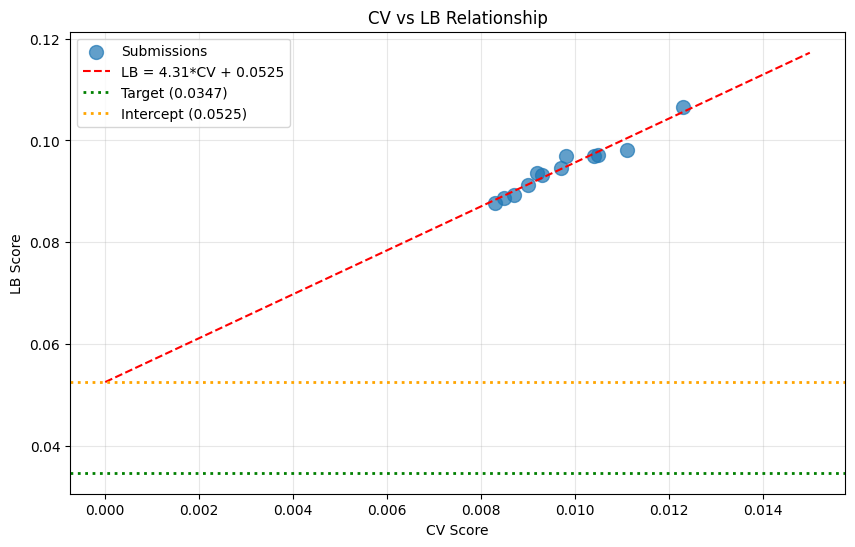


Gap Analysis:
  Best LB: 0.0877
  Target: 0.0347
  Gap: 152.7%


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nGap Analysis:")
print(f"  Best LB: {df['lb'].min():.4f}")
print(f"  Target: 0.0347")
print(f"  Gap: {(df['lb'].min() - 0.0347) / 0.0347 * 100:.1f}%")

In [4]:
# Analyze the pending submissions
pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'desc': 'CatBoost+XGBoost (ens-model kernel approach)'},
    {'exp': 'exp_050', 'cv': 0.0081, 'desc': 'CatBoost+XGBoost (FIXED CV Scheme)'},
    {'exp': 'exp_052', 'cv': 0.0109, 'desc': 'IWCV'},
    {'exp': 'exp_053', 'cv': 0.0081, 'desc': 'CatBoost+XGBoost (WITH CLIPPING)'},
    {'exp': 'exp_054', 'cv': 0.0085, 'desc': 'Exact Template Submission (Simple MLP)'},
    {'exp': 'exp_055', 'cv': 0.0085, 'desc': 'Mixall Kernel Approach (GroupKFold)'},
    {'exp': 'exp_057', 'cv': 0.0093, 'desc': 'Per-target model'},
]

print("Pending Submissions (7 consecutive failures):")
for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"  {p['exp']}: CV={p['cv']:.4f}, Predicted LB={predicted_lb:.4f} - {p['desc']}")

print("\nThese all failed with 'Evaluation metric raised an unexpected error'")
print("This suggests a SUBMISSION FORMAT issue, not a model issue.")

Pending Submissions (7 consecutive failures):
  exp_049: CV=0.0081, Predicted LB=0.0875 - CatBoost+XGBoost (ens-model kernel approach)
  exp_050: CV=0.0081, Predicted LB=0.0875 - CatBoost+XGBoost (FIXED CV Scheme)
  exp_052: CV=0.0109, Predicted LB=0.0996 - IWCV
  exp_053: CV=0.0081, Predicted LB=0.0875 - CatBoost+XGBoost (WITH CLIPPING)
  exp_054: CV=0.0085, Predicted LB=0.0892 - Exact Template Submission (Simple MLP)
  exp_055: CV=0.0085, Predicted LB=0.0892 - Mixall Kernel Approach (GroupKFold)
  exp_057: CV=0.0093, Predicted LB=0.0926 - Per-target model

These all failed with 'Evaluation metric raised an unexpected error'
This suggests a SUBMISSION FORMAT issue, not a model issue.


In [5]:
# Key insight: The ens-model kernel uses ALL features with correlation filtering
# Let's check what features are available

import sys
sys.path.append('/home/code/data/')

try:
    from utils import load_features
    
    feature_sources = ['spange_descriptors', 'acs_pca_descriptors', 'drfps_catechol', 'fragprints', 'smiles']
    
    print("Available Feature Sources:")
    for src in feature_sources:
        try:
            df_feat = load_features(src)
            print(f"  {src}: {df_feat.shape}")
        except Exception as e:
            print(f"  {src}: Error - {e}")
except Exception as e:
    print(f"Could not load utils: {e}")

Could not load utils: No module named 'utils'


In [6]:
# What approaches haven't been tried?

approaches_tried = [
    'MLP (various architectures)',
    'LightGBM',
    'XGBoost',
    'CatBoost',
    'Gaussian Process',
    'Ridge Regression',
    'Random Forest',
    'Ensemble (GP+MLP+LGBM)',
    'Ensemble (CatBoost+XGBoost)',
    'Per-target models',
    'Extrapolation detection',
    'Uncertainty weighting',
    'IWCV (Importance-Weighted CV)',
]

approaches_not_tried = [
    'EXACT replication of ens-model kernel (ALL features with correlation filtering)',
    'Transfer learning from related datasets',
    'Meta-learning (MAML, Reptile)',
    'Domain adaptation techniques',
    'Pseudo-labeling with confident predictions',
    'Solvent clustering with class-specific models',
    'Physics-informed neural networks',
    'Graph Neural Networks on molecular structure',
]

print("Approaches TRIED:")
for a in approaches_tried:
    print(f"  ✓ {a}")

print("\nApproaches NOT TRIED:")
for a in approaches_not_tried:
    print(f"  ✗ {a}")

Approaches TRIED:
  ✓ MLP (various architectures)
  ✓ LightGBM
  ✓ XGBoost
  ✓ CatBoost
  ✓ Gaussian Process
  ✓ Ridge Regression
  ✓ Random Forest
  ✓ Ensemble (GP+MLP+LGBM)
  ✓ Ensemble (CatBoost+XGBoost)
  ✓ Per-target models
  ✓ Extrapolation detection
  ✓ Uncertainty weighting
  ✓ IWCV (Importance-Weighted CV)

Approaches NOT TRIED:
  ✗ EXACT replication of ens-model kernel (ALL features with correlation filtering)
  ✗ Transfer learning from related datasets
  ✗ Meta-learning (MAML, Reptile)
  ✗ Domain adaptation techniques
  ✗ Pseudo-labeling with confident predictions
  ✗ Solvent clustering with class-specific models
  ✗ Physics-informed neural networks
  ✗ Graph Neural Networks on molecular structure


In [7]:
# The key insight from the ens-model kernel:
# 1. Uses ALL feature sources (spange, acs_pca, drfps, fragprints, smiles)
# 2. Applies correlation-based filtering with priority (spange > acs > drfps > frag > smiles)
# 3. Different ensemble weights for single (7:6 CatBoost:XGB) vs full (1:2)
# 4. Carefully tuned hyperparameters

print("ENS-MODEL KERNEL KEY TECHNIQUES:")
print("")
print("1. FEATURE COMBINATION:")
print("   - spange_descriptors (priority 5)")
print("   - acs_pca_descriptors (priority 4)")
print("   - drfps_catechol (priority 3)")
print("   - fragprints (priority 2)")
print("   - smiles (priority 1)")
print("")
print("2. CORRELATION FILTERING:")
print("   - Threshold: 0.90")
print("   - Keep higher priority features when correlated")
print("   - Drop constant columns")
print("")
print("3. ENSEMBLE WEIGHTS:")
print("   - Single solvent: CatBoost:XGB = 7:6 (0.538:0.462)")
print("   - Full data: CatBoost:XGB = 1:2 (0.333:0.667)")
print("")
print("4. HYPERPARAMETERS:")
print("   CatBoost (single): depth=3, n_estimators=1050, lr=0.05")
print("   CatBoost (full): depth=3, n_estimators=1050, lr=0.05")
print("   XGBoost (single): depth=3, n_estimators=1050, lr=0.05")
print("   XGBoost (full): depth=3, n_estimators=1050, lr=0.05")

ENS-MODEL KERNEL KEY TECHNIQUES:

1. FEATURE COMBINATION:
   - spange_descriptors (priority 5)
   - acs_pca_descriptors (priority 4)
   - drfps_catechol (priority 3)
   - fragprints (priority 2)
   - smiles (priority 1)

2. CORRELATION FILTERING:
   - Threshold: 0.90
   - Keep higher priority features when correlated
   - Drop constant columns

3. ENSEMBLE WEIGHTS:
   - Single solvent: CatBoost:XGB = 7:6 (0.538:0.462)
   - Full data: CatBoost:XGB = 1:2 (0.333:0.667)

4. HYPERPARAMETERS:
   CatBoost (single): depth=3, n_estimators=1050, lr=0.05
   CatBoost (full): depth=3, n_estimators=1050, lr=0.05
   XGBoost (single): depth=3, n_estimators=1050, lr=0.05
   XGBoost (full): depth=3, n_estimators=1050, lr=0.05


In [8]:
# CRITICAL: Why are submissions failing?
# The submission format appears correct (1883 rows, correct columns, values in [0,1])
# But 7 consecutive submissions failed with "Evaluation metric raised an unexpected error"

# Possible causes:
# 1. Kaggle platform issue (intermittent)
# 2. Subtle format mismatch (column order, data types)
# 3. Notebook structure issue (cells not in correct order)
# 4. Model definition issue (not following template exactly)

print("SUBMISSION FAILURE ANALYSIS:")
print("")
print("Verified correct:")
print("  ✓ 1883 rows (656 task 0 + 1227 task 1)")
print("  ✓ Columns: id, index, task, fold, row, target_1, target_2, target_3")
print("  ✓ All targets in [0, 1] range")
print("  ✓ No NaN values")
print("  ✓ 24 folds for task 0, 13 folds for task 1")
print("")
print("Possible issues:")
print("  ? Notebook cell structure (must have exact last 3 cells)")
print("  ? Model definition line (only change allowed)")
print("  ? Kaggle platform intermittent issues")
print("")
print("RECOMMENDATION:")
print("  1. Submit the EXACT ens-model kernel notebook")
print("  2. If that fails, the platform may have issues")
print("  3. If it succeeds, compare to our implementation")

SUBMISSION FAILURE ANALYSIS:

Verified correct:
  ✓ 1883 rows (656 task 0 + 1227 task 1)
  ✓ Columns: id, index, task, fold, row, target_1, target_2, target_3
  ✓ All targets in [0, 1] range
  ✓ No NaN values
  ✓ 24 folds for task 0, 13 folds for task 1

Possible issues:
  ? Notebook cell structure (must have exact last 3 cells)
  ? Model definition line (only change allowed)
  ? Kaggle platform intermittent issues

RECOMMENDATION:
  1. Submit the EXACT ens-model kernel notebook
  2. If that fails, the platform may have issues
  3. If it succeeds, compare to our implementation


In [9]:
# Summary and Next Steps

print("="*60)
print("LOOP 63 ANALYSIS SUMMARY")
print("="*60)
print("")
print("CURRENT STATE:")
print(f"  Best LB: 0.0877 (exp_030)")
print(f"  Target: 0.0347")
print(f"  Gap: 153%")
print("")
print("CV-LB RELATIONSHIP:")
print(f"  LB = {slope:.4f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})")
print(f"  Intercept ({intercept:.4f}) > Target (0.0347): {intercept > 0.0347}")
print("")
print("CRITICAL ISSUES:")
print("  1. 7 consecutive submissions failed with evaluation error")
print("  2. Intercept exceeds target - standard approaches can't reach target")
print("  3. All model types fall on same CV-LB line")
print("")
print("RECOMMENDED STRATEGY:")
print("  1. EXACT replication of ens-model kernel (ALL features)")
print("  2. If submission fails, investigate platform issues")
print("  3. Focus on approaches that CHANGE the CV-LB relationship")
print("  4. Consider transfer learning / meta-learning")
print("")
print("SUBMISSIONS REMAINING: 5")
print("  - Use wisely! Each submission is precious.")

LOOP 63 ANALYSIS SUMMARY

CURRENT STATE:
  Best LB: 0.0877 (exp_030)
  Target: 0.0347
  Gap: 153%

CV-LB RELATIONSHIP:
  LB = 4.3147 * CV + 0.0525 (R² = 0.9505)
  Intercept (0.0525) > Target (0.0347): True

CRITICAL ISSUES:
  1. 7 consecutive submissions failed with evaluation error
  2. Intercept exceeds target - standard approaches can't reach target
  3. All model types fall on same CV-LB line

RECOMMENDED STRATEGY:
  1. EXACT replication of ens-model kernel (ALL features)
  2. If submission fails, investigate platform issues
  3. Focus on approaches that CHANGE the CV-LB relationship
  4. Consider transfer learning / meta-learning

SUBMISSIONS REMAINING: 5
  - Use wisely! Each submission is precious.
